In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, kmeans_plusplus
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler

%matplotlib inline

In [2]:
BASE_FOLDER = Path(Path.cwd(), "data_6m")

# "Двовимірний" датасет.
Так як датасет має 3 стовпця(ознаки), то я не зовсім зрозумів, чому він називається двовимірним. Але спочатку будем виходити з того, що перший стовбець це також ознака (хоча є велике бажання рахувати його як class id)

In [3]:
df = pd.read_csv(Path(BASE_FOLDER, "data_2d.csv"))
display(df.head())
df.shape

,0.000000000000000000e+00,-7.687164597386728637e-01,4.608603078297135447e-01
0,0.0,2.687848,2.366961
1,0.0,-0.201379,0.470430
2,0.0,0.608496,1.225400
3,0.0,-0.082282,1.137218
4,0.0,2.083069,2.694482


(199, 3)

В датасеті відсутні заголовки, тому shape видав некоректну інформацію

In [4]:
columns = ["feature1", "feature2", "feature3"]
df = pd.read_csv(Path(BASE_FOLDER, "data_2d.csv"), header=None)
df.columns = columns
display(df.head(1))
df.shape

,feature1,feature2,feature3
0,0.0,-0.768716,0.46086


(200, 3)

In [5]:
df.dtypes

feature1    float64
feature2    float64
feature3    float64
dtype: object

### Проведемо дослідження данних

In [6]:
df.describe()

,feature1,feature2,feature3
count,200.000000,200.000000,200.000000
mean,0.500000,1.758886,2.211502
std,0.501255,1.239986,1.605176
min,0.000000,-1.488928,-1.344141
25%,0.000000,0.874456,0.955211
50%,0.500000,1.729753,2.282891
75%,1.000000,2.701499,3.602253
max,1.000000,4.554605,5.722027


Спробуємо обійтися без нормалізації.

Перевіримо наявність пропусків.

In [7]:
print(f"None values count: {df.isnull().sum().sum()}")

None values count: 0


Кількість ознак дозволяє нам візуалізувати оригінальний датасет

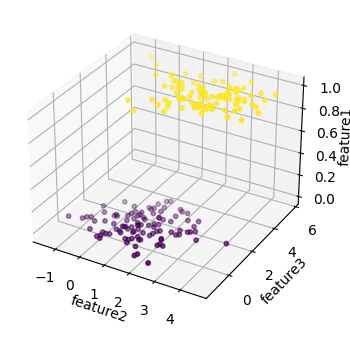

In [8]:
plt.figure(figsize=(4, 4))
ax = plt.axes(projection="3d")
ax.scatter(df["feature2"], df["feature3"], df["feature1"], c=df["feature1"], s=10);
ax.set_xlabel("feature2")
ax.set_ylabel("feature3")
ax.set_zlabel("feature1", rotation=90)
ax.xaxis.labelpad = -0.8
ax.yaxis.labelpad = -0.8
ax.zaxis.labelpad = -0.8
plt.show()

Глянемо розподіл значень по ознакам

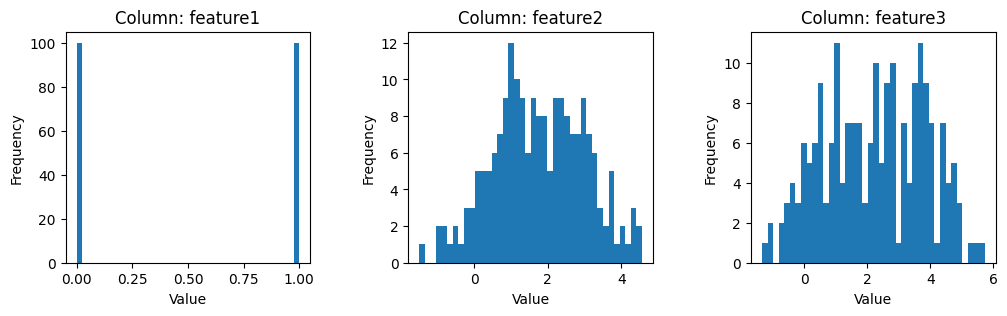

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12, 3),
                        gridspec_kw={"wspace": 0.4, "hspace": 0.4})

for i, col in enumerate(df.columns):
    axs[i].hist(df[col], bins=40)
    axs[i].set_title(f"Column: {col}")
    axs[i].set_ylabel("Frequency")
    axs[i].set_xlabel("Value")
plt.show()

In [10]:
df.groupby("feature1")["feature1"].count()

feature1
0.0    100
1.0    100
Name: feature1, dtype: int64

Бачимо, що "feature1" ділить наш набір навпіл. Якщо у нас була б інформація про про зміст наших данних, особливо "feature1" - то можливо на цьому кластерізацію можна було б і закінчувати. Але припустимо що в датасеті показники якихось двох датчиків. І перший стовбець є номером датчика. Тоді кластеризувати по "feature1" не є гут. Розглянемо наш датасет без "feature1".

In [11]:
df_2f = df.drop("feature1", axis=1)
df_2f.head()

,feature2,feature3
0,-0.768716,0.460860
1,2.687848,2.366961
2,-0.201379,0.470430
3,0.608496,1.225400
4,-0.082282,1.137218


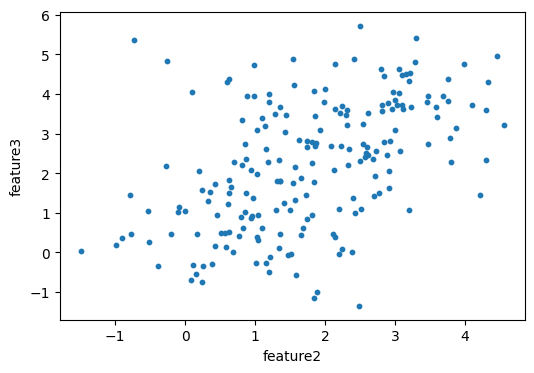

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_2f["feature2"], df_2f["feature3"], s=10)
ax.set_xlabel("feature2")
ax.set_ylabel("feature3")
plt.show()

Глянемо не кореляцію ознак

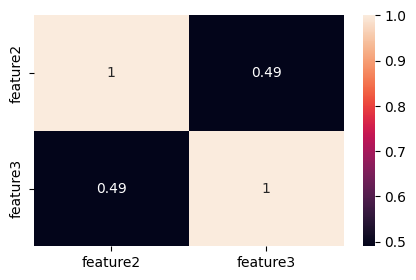

In [13]:
plt.figure(figsize=(5, 3))
sns.heatmap(df_2f.corr(), annot=True)
plt.show()

данні слабокорельовані що є гут

### Реалізація кластерізації за допомогою алгоритму  K-Means

Щоб знайти оптимальну кількість кластерів, скористаємося ліктевим методом.

In [14]:
sum_distances = []

for n_clusters in range(1, 6):
    kmeans = KMeans(n_clusters=n_clusters, n_init="auto", random_state=42)
    sum_distances += [kmeans.fit(df_2f).inertia_]

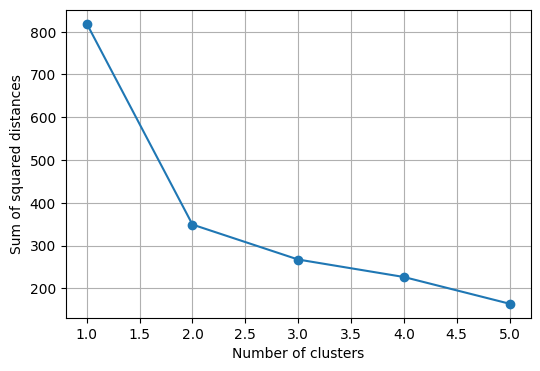

In [15]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(list(range(1, 6)), sum_distances, marker="o")
ax.grid()
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Sum of squared distances")
plt.show()

Як бачимо оптимальним варіантом кількості кластерів є 2.

Простір інтернету просто кишить попередженнями, що алгоритм K-Means дуже чутливий до початкової ініціалізації кластерів. І тому алгоритм K-Means за замовчуванням використовує ініціалізацію k-means++.

Спробуємо перевірити це на практиці

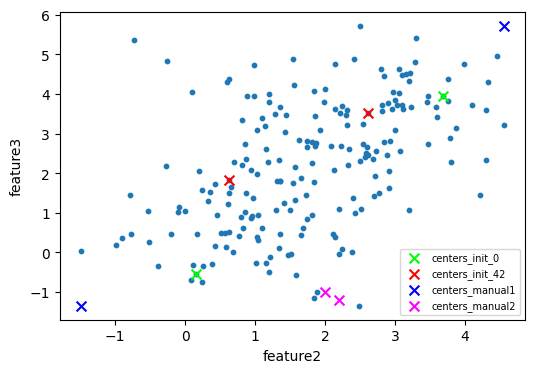

In [16]:
centers_init_0, _ = kmeans_plusplus(np.array(df_2f), n_clusters=2, random_state=0)
centers_init_42, _ = kmeans_plusplus(np.array(df_2f), n_clusters=2, random_state=42)
centers_init_manual1 = np.array([[df_2f["feature2"].max(), df_2f["feature3"].max()], 
                                 [df_2f["feature2"].min(), df_2f["feature3"].min()]])
centers_init_manual2 = np.array([[2., -1.], [2.2, -1.2]])

colors = ["lime", "red", "blue", "fuchsia"]

init_centers = {"centers_init_0": centers_init_0, 
                "centers_init_42": centers_init_42, 
                "centers_manual1": centers_init_manual1,
                "centers_manual2": centers_init_manual2}

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(df_2f["feature2"], df_2f["feature3"], s=10, label="_nolegend_")
for i, centers in enumerate(init_centers.values()):
    ax.scatter(centers[:, 0], centers[:, 1], s=50, c=colors[i], marker="x")
ax.set_xlabel("feature2")
ax.set_ylabel("feature3")
labels = list(init_centers) # ["inits, random_state=0", "inits, random_state=42", "inits manual1", "inits manual1"]
plt.legend(labels=labels, loc="lower right", fontsize="7")
plt.show()

Бачимо, що  k-means++ більш адекватно проініціалізував центри ніж я в останньому випадку.

__Виконаємо розподіл нашого датасету з різними початковими ініціалізаціями центрів кластерів__

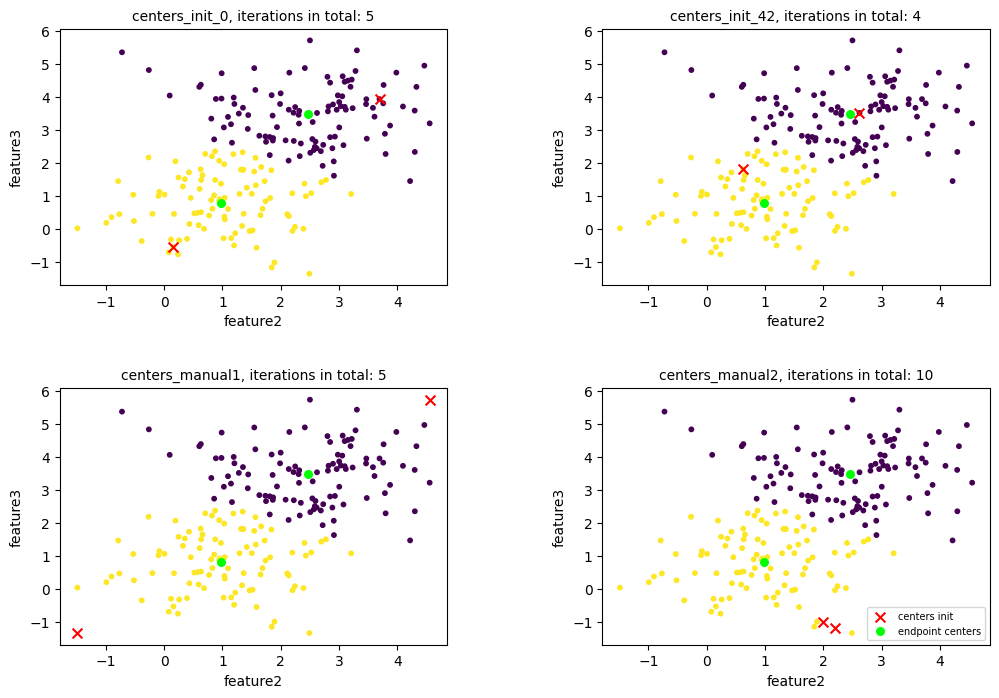

In [17]:
kms = [KMeans(n_clusters=2, init=centers, n_init=1).fit(df_2f) for centers in init_centers.values()]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8),
                        gridspec_kw={"wspace": 0.4, "hspace": 0.4})

for i, ax in enumerate(axs.flat[:len(kms)]):
    ax.scatter(df_2f["feature2"], df_2f["feature3"], c=kms[i].labels_, s=10, label="_nolegend_")
    ax.scatter(list(init_centers.values())[i][:, 0], list(init_centers.values())[i][:, 1], s=50, c="red", marker="x")
    ax.scatter(kms[i].cluster_centers_[:, 0], kms[i].cluster_centers_[:, 1], s=30, c="lime", marker="o")
    ax.set_title(f"{list(init_centers)[i]}, iterations in total: {kms[i].n_iter_}", fontsize="10")
    ax.set_xlabel("feature2")
    ax.set_ylabel("feature3")
    labels = ["centers init", "endpoint centers"]
plt.legend(labels=labels, loc="lower right", fontsize="7")
plt.show()

In [18]:
np.array([km.cluster_centers_ for km in kms]).reshape(-1,4)

array([[2.46540572, 3.48660748, 0.97799508, 0.80217417],
       [2.46540572, 3.48660748, 0.97799508, 0.80217417],
       [2.46540572, 3.48660748, 0.97799508, 0.80217417],
       [2.46540572, 3.48660748, 0.97799508, 0.80217417]])

кінцеві координати цетрів у всіх 4 випадках однакові.

В нашому випадку різна початкова ініціалізація центрів не вплинула на кінцевий результат розподілу, але вплинула на кількість ітерацій для його досягнення.

# Датасет mnist.

In [19]:
df_mnist = pd.read_csv(Path(BASE_FOLDER, "mnist.csv"), header=None)
display(df_mnist.head())
df_mnist.shape

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(500, 785)

In [20]:
df_mnist.dtypes

0      int64
1      int64
2      int64
3      int64
4      int64
       ...  
780    int64
781    int64
782    int64
783    int64
784    int64
Length: 785, dtype: object

In [21]:
len(df_mnist.dtypes.unique())

1

### Проведемо дослідження данних

In [22]:
df_mnist.describe()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
count,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0,...,500.000000,500.000000,500.0,500.0,500.0,500.0,500.0,500.0,500.0,500.0
mean,4.378000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.506000,0.256000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,2.873958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.314504,5.724334,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,253.000000,128.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Нулі виглядають дуже підозріло

In [23]:
print(f"None values count: {df_mnist.isnull().sum().sum()}")

None values count: 0


In [24]:
result = df_mnist.eq(0).sum()
result = result.loc[lambda x : x == 500]
len(result.index)

209

Дропнем з нашого датасету нульові стовпці

In [25]:
df_mnist_1 = df_mnist.drop(result.index, axis=1)

In [26]:
df_mnist_1.shape

(500, 576)

Нормалізуємо датасет

In [27]:
X_norm = pd.DataFrame(StandardScaler().fit_transform(df_mnist_1))
X_norm.describe()

,0,1,2,3,4,5,6,7,8,9,...,566,567,568,569,570,571,572,573,574,575
count,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,...,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02,5.000000e+02
mean,-2.131628e-17,1.776357e-17,1.065814e-17,7.105427e-18,-3.552714e-18,1.776357e-18,6.217249e-17,5.329071e-17,7.105427e-18,2.131628e-17,...,-1.332268e-17,-4.085621e-17,2.486900e-17,3.552714e-18,2.131628e-17,-1.953993e-17,2.131628e-17,-2.842171e-17,3.197442e-17,2.486900e-17
std,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,...,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00,1.001002e+00
min,-1.524860e+00,-4.476615e-02,-4.476615e-02,-4.476615e-02,-6.245238e-02,-7.794857e-02,-1.121419e-01,-1.321195e-01,-1.263987e-01,-9.960475e-02,...,-1.467552e-01,-1.106654e-01,-8.442697e-02,-4.476615e-02,-5.963517e-02,-7.745750e-02,-6.685556e-02,-5.151044e-02,-4.476615e-02,-4.476615e-02
25%,-8.282590e-01,-4.476615e-02,-4.476615e-02,-4.476615e-02,-6.245238e-02,-7.794857e-02,-1.121419e-01,-1.321195e-01,-1.263987e-01,-9.960475e-02,...,-1.467552e-01,-1.106654e-01,-8.442697e-02,-4.476615e-02,-5.963517e-02,-7.745750e-02,-6.685556e-02,-5.151044e-02,-4.476615e-02,-4.476615e-02
50%,-1.316576e-01,-4.476615e-02,-4.476615e-02,-4.476615e-02,-6.245238e-02,-7.794857e-02,-1.121419e-01,-1.321195e-01,-1.263987e-01,-9.960475e-02,...,-1.467552e-01,-1.106654e-01,-8.442697e-02,-4.476615e-02,-5.963517e-02,-7.745750e-02,-6.685556e-02,-5.151044e-02,-4.476615e-02,-4.476615e-02
75%,9.132443e-01,-4.476615e-02,-4.476615e-02,-4.476615e-02,-6.245238e-02,-7.794857e-02,-1.121419e-01,-1.321195e-01,-1.263987e-01,-9.960475e-02,...,-1.467552e-01,-1.106654e-01,-8.442697e-02,-4.476615e-02,-5.963517e-02,-7.745750e-02,-6.685556e-02,-5.151044e-02,-4.476615e-02,-4.476615e-02
max,1.609846e+00,2.233831e+01,2.233831e+01,2.233831e+01,2.064658e+01,1.422197e+01,1.102322e+01,1.126520e+01,1.108355e+01,1.565754e+01,...,8.818089e+00,1.113365e+01,1.523965e+01,2.233831e+01,2.139017e+01,1.356930e+01,1.577220e+01,2.209470e+01,2.233831e+01,2.233831e+01


Спробуємо оцінити оптимальну кількість головних компонент

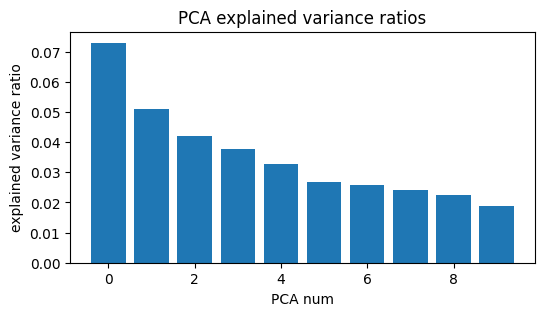

In [28]:
pca = PCA(n_components=10)
X_norm_pca = pca.fit_transform(X_norm)
data_plot = pd.DataFrame(pca.explained_variance_ratio_).reset_index()

fig, ax = plt.subplots(figsize=(6, 3))
ax.bar(data_plot.iloc[:, 0], data_plot.iloc[:, 1])
ax.set_title("PCA explained variance ratios")
ax.set_xlabel("PCA num")
ax.set_ylabel("explained variance ratio")
plt.show()

На око або 2 або 3 компоненти. (Бачив математичну оцінку, але іншим разом)

Подивимось на функцію ліктя з різною кількістю головних компонент.

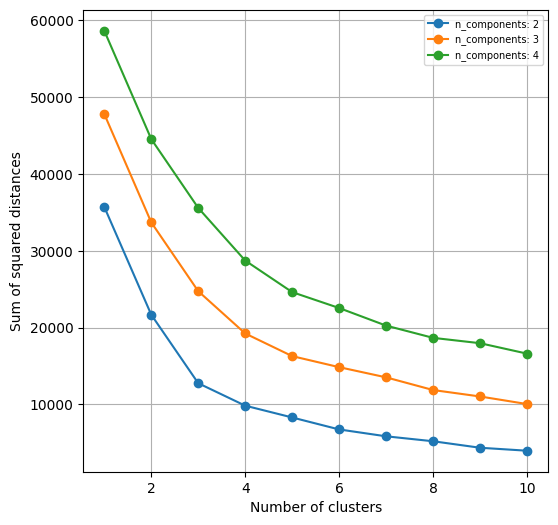

In [29]:
fig, ax = plt.subplots(figsize=(6, 6))

pcas = [PCA(n_components=2), PCA(n_components=3) , PCA(n_components=4)]

for i, pca in enumerate(pcas):
    X_norm_pca = pca.fit_transform(X_norm)

    sum_distances = []

    for n_clusters in range(1, 11):
        kms = KMeans(n_clusters=n_clusters, n_init="auto", random_state=0)
        sum_distances += [kms.fit(X_norm_pca).inertia_]
    
    ax.plot(list(range(1, 11)), sum_distances, marker="o", label = f"n_components: {i+2}")
    labels = ["centers init"]

ax.grid()
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Sum of squared distances")
plt.legend(loc="upper right", fontsize="7")
plt.show()    

Бачимо, що більше виражений лікоть для n_components=2. І в цьому випадку оптимальним є 3 кластера.

Подивимось на наші данні в розрізі двох головних компонент

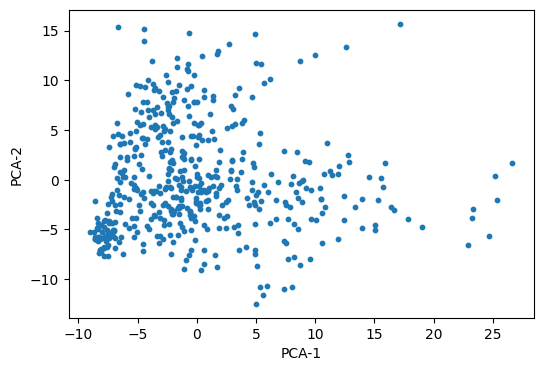

In [30]:
X_norm_pca = PCA(n_components=2).fit_transform(X_norm)

fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_norm_pca[:, 0], X_norm_pca[:, 1], s=10)
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")

plt.show()

Подивимось на розподіл значень по головним компонентам

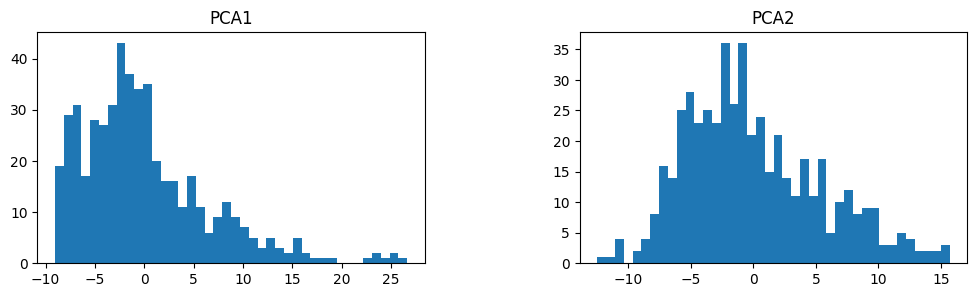

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 3),
                        gridspec_kw={"wspace": 0.4, "hspace": 0.4})

for i in range(2):
    axs[i].hist(X_norm_pca[:, i], bins=40)
    axs[i].set_title(f"PCA{i+1}")
plt.show()

Глянемо на кореляцію головних компонент

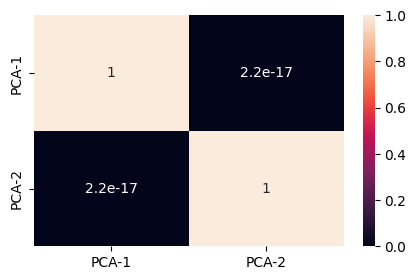

In [32]:
df_tmp = pd.DataFrame(X_norm_pca)
df_tmp.columns = ["PCA-1", "PCA-2"]
plt.figure(figsize=(5, 3))
sns.heatmap(df_tmp.corr(), annot=True)
plt.show()

Маємо підтвердження теорії, що головні компоненти ніяк не пов'язані між собою.

__Виконаємо розподіл нашого датасету__

In [33]:
km = KMeans(n_clusters=3, init="k-means++", n_init="auto").fit(X_norm_pca)

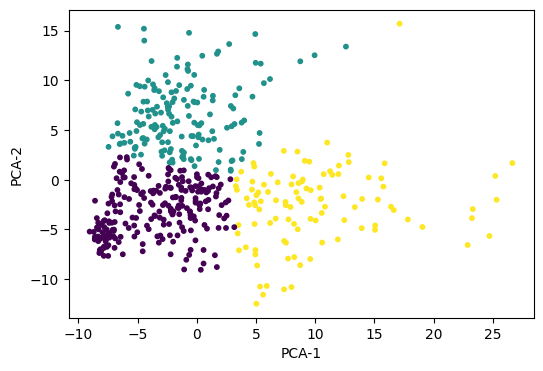

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.scatter(X_norm_pca[:, 0], X_norm_pca[:, 1], c=km.labels_, s=10)
ax.set_xlabel("PCA-1")
ax.set_ylabel("PCA-2")
plt.show()

Ну якось так

__Варіант з повним датасетом.__

Пробував з 3 кластерами - працює дуже дивно. Типу підказує, що буде краще з двома. Як це пояснити не знаю. Тому варіант буде такий.

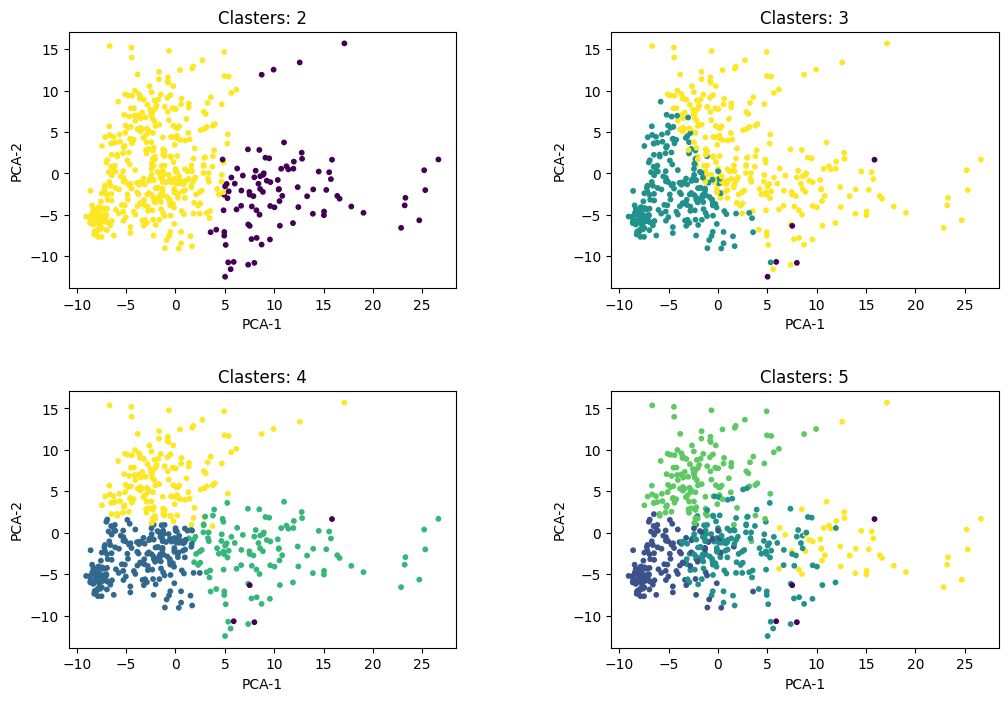

In [35]:
centers_init = []

for i in range(2,6):
    centers, _ = kmeans_plusplus(np.array(X_norm), n_clusters=i, random_state=0)
    centers_init.append(centers)
    
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8),
                        gridspec_kw={"wspace": 0.4, "hspace": 0.4})

for i, ax in enumerate(axs.flat[:len(centers_init)]):
    km = KMeans(n_clusters=i+2, init=centers_init[i], n_init=1).fit(X_norm)
    ax.scatter(X_norm_pca[:, 0], X_norm_pca[:, 1], c=km.labels_, s=10)
    ax.set_title(f"Clasters: {i+2}")
    ax.set_xlabel("PCA-1")
    ax.set_ylabel("PCA-2")
plt.show()

Бачимо, що варіант з 4-ма кластерами найбільше схожий на наш варіант з розмірністю 2 та 3-ма кластерами. Чим це пояснити - не знаю. Буду вдячний за підказку.

# Висновки.

__Алгоритм к-середніх (K-means) в комбінації з ліктевим методом та PCA непогано справився з завданням кластеризації вихідних датасетів.__  
Підтверджено на практиці:  
1. Користь від використання ліктевого методу для знаходження оптимальної кількості кластерів в випадках, коли ми зовсім не розуміємо зміст данних.
2. Чутливість K-means до початкової ініціалізації кластерів. 
3. Алгоритм PCA є гарним рішенням для зменшення розмірності данних, але все таки викликає спотворення інформації. Проте в залежності від якості та кількості ознак може показати і кращий результат ніж на оригінальних данних. Ну а по швидкості виконання результат завжди кращий.